In [24]:
import os
import json
import warnings
import numpy as np
from settings import IMAGE_HEIGHT, IMAGE_WIDTH, OUT_DIR

warnings.filterwarnings("ignore")

# Create output directory
if not os.path.exists(OUT_DIR):
    os.mkdir(OUT_DIR)

### Define the train function

In [25]:
import glob
from time import time
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
from core.models.nts_net import NTSModel
from core.loss import list_loss, ranking_loss
from torch.optim.lr_scheduler import MultiStepLR
import shutil

def train(train, val, n_classes, epochs, batch_size, hr, scheduler_gamma=0.5):

    # Identify device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Setup model output dir
    folder_name = "train_{}".format(int(time()))
    out_path = os.path.join(OUT_DIR, folder_name)
    os.mkdir(out_path)

    # Setup dataloader
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=True, num_workers=2)

    model = NTSModel(top_n=hr["proposal_num"], n_classes=n_classes, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH).to(device)
    criterion = torch.nn.CrossEntropyLoss()

    # Setup optimizers
    resnet_parameters = list(model.resnet.parameters())
    navigator_parameters = list(model.navigator.parameters())
    concat_parameters = list(model.concat_net.parameters())
    partcls_parameters = list(model.partcls_net.parameters())

    resnet_optim_params = {"lr": hr["resnet_lr"], "weight_decay": hr["resnet_weight_decay"], "momentum": hr["resnet_momentum"]}
    navigator_optim_params = {"lr": hr["navigator_lr"], "weight_decay": hr["navigator_weight_decay"], "momentum": hr["navigator_momentum"]}
    concat_optim_params = {"lr": hr["concat_lr"], "weight_decay": hr["concat_weight_decay"], "momentum": hr["concat_momentum"]}
    partcls_optim_params = {"lr": hr["partcls_lr"], "weight_decay": hr["partcls_weight_decay"], "momentum": hr["partcls_momentum"]}

    resnet_optimizer = torch.optim.SGD(resnet_parameters, **resnet_optim_params)
    navigator_optimizer = torch.optim.SGD(navigator_parameters, **navigator_optim_params)
    concat_optimizer = torch.optim.SGD(concat_parameters, **concat_optim_params)
    partcls_optimizer = torch.optim.SGD(partcls_parameters, **partcls_optim_params)

    # Setup learning rate scheduler
    scheduler_interval = [int(epochs*0.25), int(epochs*0.5), int(epochs*0.75)]

    schedulers = [MultiStepLR(resnet_optimizer, milestones=scheduler_interval, gamma=scheduler_gamma),
                MultiStepLR(navigator_optimizer, milestones=scheduler_interval, gamma=scheduler_gamma),
                MultiStepLR(concat_optimizer, milestones=scheduler_interval, gamma=scheduler_gamma),
                MultiStepLR(partcls_optimizer, milestones=scheduler_interval, gamma=scheduler_gamma)]

    model = nn.DataParallel(model)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
    }

    for epoch in range(epochs):

        for scheduler in schedulers:
            scheduler.step()

        epoch_loss = 0
        epoch_accuracy = 0
        epoch_val_loss = 0
        epoch_val_accuracy = 0
        with tqdm(total=len(train_loader)) as pbar:
            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                batch_size = inputs.size(0)

                resnet_optimizer.zero_grad()
                navigator_optimizer.zero_grad()
                concat_optimizer.zero_grad()
                partcls_optimizer.zero_grad()

                resnet_logits, concat_logits, part_logits, top_n_idxs, top_n_proba = model(inputs)
                
                # Losses
                resnet_loss = criterion(resnet_logits, labels)
                navigator_loss = list_loss(part_logits.view(batch_size * hr["proposal_num"], -1),
                                        labels.unsqueeze(1).repeat(1, hr["proposal_num"]).view(-1)).view(batch_size, hr["proposal_num"])
                concat_loss = criterion(concat_logits, labels)
                rank_loss = ranking_loss(top_n_proba, navigator_loss, proposal_num=hr["proposal_num"])
                partcls_loss = criterion(part_logits.view(batch_size * hr["proposal_num"], -1),
                                    labels.unsqueeze(1).repeat(1, hr["proposal_num"]).view(-1))
                
                loss = resnet_loss + concat_loss + rank_loss + partcls_loss
                loss.backward()

                resnet_optimizer.step()
                navigator_optimizer.step()
                concat_optimizer.step()
                partcls_optimizer.step()

                accuracy = (concat_logits.argmax(dim=1) == labels).float().mean()
                
                epoch_loss += concat_loss.item()
                epoch_accuracy += accuracy.item()

                pbar.set_postfix_str("Train loss: {:.4f}, Train accuracy: {:.4f}".format(epoch_loss / (i+1), epoch_accuracy / (i+1)))
                pbar.update(1)

        with tqdm(total=(len(val_loader))) as pbar:
            with torch.no_grad():
                for i, (inputs, labels) in enumerate(val_loader):
                    inputs, labels = inputs.to(device), labels.to(device)
                    batch_size = inputs.size(0)

                    _, concat_logits, _, _, _ = model(inputs)

                    concat_loss = criterion(concat_logits, labels)
                    

                    accuracy = (concat_logits.argmax(dim=1) == labels).float().mean()

                    epoch_val_loss += concat_loss.item()
                    epoch_val_accuracy += accuracy.item()


                    pbar.set_postfix_str("Val loss: {:.4f}, Val accuracy: {:.4f}".format(epoch_val_loss / (i+1), epoch_val_accuracy / (i+1)))
                    pbar.update(1)

        epoch_loss = epoch_loss/len(train_loader)
        epoch_val_loss = epoch_val_loss/len(val_loader)

        epoch_accuracy = epoch_accuracy/len(train_loader)
        epoch_val_accuracy = epoch_val_accuracy/len(val_loader)

        history["train_loss"].append(epoch_loss)
        history["val_loss"].append(epoch_val_loss)    

        history["train_accuracy"].append(epoch_accuracy)
        history["val_accuracy"].append(epoch_val_accuracy) 

        print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f} - Val Loss: {epoch_val_loss:.4f} - Val Accuracy: {epoch_val_accuracy:.4f}")

        torch.save({
            "train_accuracy": history["train_accuracy"][-1],
            "val_accuracy": history["val_accuracy"][-1],
            "proposal_num": hr["proposal_num"],
            "n_classes": n_classes,
            "state_dict": model.module.state_dict(),
        }, os.path.join(out_path, f"epoch_{epoch+1}.ckpt"))


    # Remove all but the best checkpoints
    best_epoch_idx = np.argmax(history["val_accuracy"])
    os.rename(os.path.join(out_path, f"epoch_{best_epoch_idx + 1}.ckpt"), os.path.join(out_path, "model.ckpt"))

    for file in glob.glob(f"{out_path}/**"):
        if not file.endswith('model.ckpt'):    
                os.remove(file)

    # Update latest model weights
    src = os.path.join(out_path, "model.ckpt")
    dst = os.path.join(OUT_DIR, "latest_model.ckpt")
    shutil.copyfile(src, dst)

    # Report best
    print("Best epoch:", best_epoch_idx+1)
    print("Best val accuracy:", history["val_accuracy"][best_epoch_idx])

    return history

### Load the train data

In [26]:
from torchvision.transforms import Compose, Resize, ToTensor, RandomHorizontalFlip, RandomCrop
from torch.utils.data import ConcatDataset
from torchvision.datasets import FGVCAircraft
from PIL import Image

transform = Compose([
  Resize((IMAGE_HEIGHT, IMAGE_WIDTH), Image.BILINEAR),
  ToTensor(),
])

augment_transform = Compose([
    Resize((int(IMAGE_HEIGHT * 1.5), int(IMAGE_WIDTH * 1.5)), Image.BILINEAR),
    RandomCrop((IMAGE_HEIGHT, IMAGE_WIDTH)),
    RandomHorizontalFlip(),
    ToTensor(),
])

val_transform = Compose([
  Resize((IMAGE_HEIGHT, IMAGE_WIDTH), Image.BILINEAR),
  ToTensor(),
])

# Load data
train_data = FGVCAircraft(root="data", split="train", transform=transform, download=True)
n_classes = len(train_data.classes)
augmented_data = FGVCAircraft(root="data", split="train", transform=augment_transform, download=True)

train_data = ConcatDataset([train_data, augmented_data])
val_data = FGVCAircraft(root="data", split="val", transform=val_transform, download=True)

print("Train data size:", len(train_data))
print("Val data size:", len(val_data))

Train data size: 6668
Val data size: 3333


### Train the model

In [31]:
from pprint import pprint
# Load hyperparameters
with open("hyperparameters.json", "r") as f:
    hr = json.load(f)

print("Hyperparameters:")
pprint(hr, sort_dicts=False)

Hyperparameters:
{'proposal_num': 4,
 'concat_lr': 0.017421479104985847,
 'resnet_lr': 0.023663449413508245,
 'partcls_lr': 0.021992845516824015,
 'navigator_lr': 0.008795790041545189,
 'concat_momentum': 0.95,
 'resnet_momentum': 0.95,
 'partcls_momentum': 0.95,
 'navigator_momentum': 0.95,
 'concat_weight_decay': 0.009226112294479522,
 'resnet_weight_decay': 0.00246484552746257,
 'partcls_weight_decay': 0.005071394828965506,
 'navigator_weight_decay': 0.001719879259014504}


In [30]:
NUM_EPOCHS = 40
BATCH_SIZE = 8

history = train(train_data, val_data, n_classes=n_classes, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, hr=hr)

100%|██████████| 417/417 [00:46<00:00,  8.97it/s, Val loss: 2.7748, Val accuracy: 0.2504]


Epoch 1 - Loss: 3.9718 - Accuracy: 0.1081 - Val Loss: 2.7748 - Val Accuracy: 0.2504


100%|██████████| 417/417 [00:46<00:00,  9.00it/s, Val loss: 2.1023, Val accuracy: 0.4337]


Epoch 2 - Loss: 1.9890 - Accuracy: 0.4388 - Val Loss: 2.1023 - Val Accuracy: 0.4337


100%|██████████| 417/417 [00:46<00:00,  8.93it/s, Val loss: 1.5060, Val accuracy: 0.5798]


Epoch 3 - Loss: 1.1720 - Accuracy: 0.6416 - Val Loss: 1.5060 - Val Accuracy: 0.5798


100%|██████████| 417/417 [00:46<00:00,  9.03it/s, Val loss: 1.3271, Val accuracy: 0.6422]


Epoch 4 - Loss: 0.7093 - Accuracy: 0.7735 - Val Loss: 1.3271 - Val Accuracy: 0.6422


100%|██████████| 417/417 [00:46<00:00,  8.99it/s, Val loss: 1.2129, Val accuracy: 0.6810]


Epoch 5 - Loss: 0.4632 - Accuracy: 0.8471 - Val Loss: 1.2129 - Val Accuracy: 0.6810


100%|██████████| 417/417 [00:46<00:00,  9.00it/s, Val loss: 1.2551, Val accuracy: 0.6953]


Epoch 6 - Loss: 0.2833 - Accuracy: 0.9053 - Val Loss: 1.2551 - Val Accuracy: 0.6953


100%|██████████| 417/417 [00:46<00:00,  9.00it/s, Val loss: 1.1060, Val accuracy: 0.7254]


Epoch 7 - Loss: 0.1850 - Accuracy: 0.9379 - Val Loss: 1.1060 - Val Accuracy: 0.7254


100%|██████████| 417/417 [00:46<00:00,  9.03it/s, Val loss: 1.1672, Val accuracy: 0.7374]


Epoch 8 - Loss: 0.1297 - Accuracy: 0.9559 - Val Loss: 1.1672 - Val Accuracy: 0.7374


100%|██████████| 417/417 [00:46<00:00,  9.01it/s, Val loss: 1.1476, Val accuracy: 0.7418]


Epoch 9 - Loss: 0.0846 - Accuracy: 0.9732 - Val Loss: 1.1476 - Val Accuracy: 0.7418


100%|██████████| 417/417 [00:46<00:00,  9.03it/s, Val loss: 1.0146, Val accuracy: 0.7798]


Epoch 10 - Loss: 0.0304 - Accuracy: 0.9919 - Val Loss: 1.0146 - Val Accuracy: 0.7798


100%|██████████| 417/417 [00:47<00:00,  8.69it/s, Val loss: 1.0543, Val accuracy: 0.7710]


Epoch 11 - Loss: 0.0255 - Accuracy: 0.9924 - Val Loss: 1.0543 - Val Accuracy: 0.7710


100%|██████████| 417/417 [00:46<00:00,  9.04it/s, Val loss: 1.0693, Val accuracy: 0.7657]


Epoch 12 - Loss: 0.0179 - Accuracy: 0.9951 - Val Loss: 1.0693 - Val Accuracy: 0.7657


100%|██████████| 417/417 [00:46<00:00,  8.96it/s, Val loss: 1.0414, Val accuracy: 0.7803]


Epoch 13 - Loss: 0.0157 - Accuracy: 0.9960 - Val Loss: 1.0414 - Val Accuracy: 0.7803


100%|██████████| 417/417 [00:46<00:00,  8.97it/s, Val loss: 1.0035, Val accuracy: 0.7813]


Epoch 14 - Loss: 0.0126 - Accuracy: 0.9957 - Val Loss: 1.0035 - Val Accuracy: 0.7813


100%|██████████| 417/417 [00:46<00:00,  8.98it/s, Val loss: 1.0206, Val accuracy: 0.7831]


Epoch 15 - Loss: 0.0106 - Accuracy: 0.9972 - Val Loss: 1.0206 - Val Accuracy: 0.7831


100%|██████████| 417/417 [00:46<00:00,  8.97it/s, Val loss: 1.0437, Val accuracy: 0.7776]


Epoch 16 - Loss: 0.0083 - Accuracy: 0.9976 - Val Loss: 1.0437 - Val Accuracy: 0.7776


100%|██████████| 417/417 [00:46<00:00,  9.02it/s, Val loss: 1.0259, Val accuracy: 0.7798]


Epoch 17 - Loss: 0.0063 - Accuracy: 0.9985 - Val Loss: 1.0259 - Val Accuracy: 0.7798


100%|██████████| 417/417 [00:46<00:00,  8.95it/s, Val loss: 1.0283, Val accuracy: 0.7829]


Epoch 18 - Loss: 0.0063 - Accuracy: 0.9987 - Val Loss: 1.0283 - Val Accuracy: 0.7829


100%|██████████| 417/417 [00:46<00:00,  8.99it/s, Val loss: 1.0303, Val accuracy: 0.7777]


Epoch 19 - Loss: 0.0041 - Accuracy: 0.9993 - Val Loss: 1.0303 - Val Accuracy: 0.7777


100%|██████████| 417/417 [00:46<00:00,  9.04it/s, Val loss: 1.0550, Val accuracy: 0.7789]


Epoch 20 - Loss: 0.0037 - Accuracy: 0.9993 - Val Loss: 1.0550 - Val Accuracy: 0.7789


100%|██████████| 417/417 [00:46<00:00,  8.97it/s, Val loss: 1.0446, Val accuracy: 0.7852]


Epoch 21 - Loss: 0.0045 - Accuracy: 0.9985 - Val Loss: 1.0446 - Val Accuracy: 0.7852


100%|██████████| 417/417 [00:46<00:00,  9.00it/s, Val loss: 1.0249, Val accuracy: 0.7810]


Epoch 22 - Loss: 0.0025 - Accuracy: 0.9994 - Val Loss: 1.0249 - Val Accuracy: 0.7810


100%|██████████| 417/417 [00:46<00:00,  9.02it/s, Val loss: 1.0196, Val accuracy: 0.7899]


Epoch 23 - Loss: 0.0030 - Accuracy: 0.9994 - Val Loss: 1.0196 - Val Accuracy: 0.7899


100%|██████████| 417/417 [00:46<00:00,  8.99it/s, Val loss: 1.0035, Val accuracy: 0.7902]


Epoch 24 - Loss: 0.0024 - Accuracy: 0.9999 - Val Loss: 1.0035 - Val Accuracy: 0.7902


100%|██████████| 417/417 [00:46<00:00,  9.01it/s, Val loss: 1.0003, Val accuracy: 0.7942]


Epoch 25 - Loss: 0.0021 - Accuracy: 0.9999 - Val Loss: 1.0003 - Val Accuracy: 0.7942


100%|██████████| 417/417 [00:46<00:00,  8.98it/s, Val loss: 1.0345, Val accuracy: 0.7877]


Epoch 26 - Loss: 0.0027 - Accuracy: 0.9997 - Val Loss: 1.0345 - Val Accuracy: 0.7877


100%|██████████| 417/417 [00:46<00:00,  9.00it/s, Val loss: 0.9945, Val accuracy: 0.7935]


Epoch 27 - Loss: 0.0017 - Accuracy: 1.0000 - Val Loss: 0.9945 - Val Accuracy: 0.7935


100%|██████████| 417/417 [00:46<00:00,  8.98it/s, Val loss: 0.9779, Val accuracy: 0.7898]


Epoch 28 - Loss: 0.0024 - Accuracy: 0.9997 - Val Loss: 0.9779 - Val Accuracy: 0.7898


100%|██████████| 417/417 [00:46<00:00,  9.00it/s, Val loss: 1.0086, Val accuracy: 0.7834]


Epoch 29 - Loss: 0.0027 - Accuracy: 0.9991 - Val Loss: 1.0086 - Val Accuracy: 0.7834


100%|██████████| 417/417 [00:46<00:00,  8.95it/s, Val loss: 1.0294, Val accuracy: 0.7816]


Epoch 30 - Loss: 0.0017 - Accuracy: 0.9999 - Val Loss: 1.0294 - Val Accuracy: 0.7816


100%|██████████| 417/417 [00:46<00:00,  9.01it/s, Val loss: 1.0420, Val accuracy: 0.7819]


Epoch 31 - Loss: 0.0017 - Accuracy: 0.9996 - Val Loss: 1.0420 - Val Accuracy: 0.7819


100%|██████████| 417/417 [00:46<00:00,  8.97it/s, Val loss: 0.9831, Val accuracy: 0.7946]


Epoch 32 - Loss: 0.0023 - Accuracy: 0.9994 - Val Loss: 0.9831 - Val Accuracy: 0.7946


100%|██████████| 417/417 [00:46<00:00,  8.95it/s, Val loss: 0.9896, Val accuracy: 0.7911]


Epoch 33 - Loss: 0.0015 - Accuracy: 0.9997 - Val Loss: 0.9896 - Val Accuracy: 0.7911


100%|██████████| 417/417 [00:46<00:00,  8.98it/s, Val loss: 0.9900, Val accuracy: 0.7956]


Epoch 34 - Loss: 0.0014 - Accuracy: 0.9999 - Val Loss: 0.9900 - Val Accuracy: 0.7956


100%|██████████| 417/417 [00:46<00:00,  8.97it/s, Val loss: 0.9978, Val accuracy: 0.7882]


Epoch 35 - Loss: 0.0016 - Accuracy: 0.9997 - Val Loss: 0.9978 - Val Accuracy: 0.7882


100%|██████████| 417/417 [00:46<00:00,  8.96it/s, Val loss: 1.0078, Val accuracy: 0.7966]


Epoch 36 - Loss: 0.0018 - Accuracy: 0.9997 - Val Loss: 1.0078 - Val Accuracy: 0.7966


100%|██████████| 417/417 [00:46<00:00,  8.96it/s, Val loss: 1.0108, Val accuracy: 0.7981]


Epoch 37 - Loss: 0.0018 - Accuracy: 0.9997 - Val Loss: 1.0108 - Val Accuracy: 0.7981


100%|██████████| 417/417 [00:46<00:00,  9.00it/s, Val loss: 1.0241, Val accuracy: 0.7894]


Epoch 38 - Loss: 0.0012 - Accuracy: 1.0000 - Val Loss: 1.0241 - Val Accuracy: 0.7894


100%|██████████| 417/417 [00:46<00:00,  8.99it/s, Val loss: 0.9799, Val accuracy: 0.7995]


Epoch 39 - Loss: 0.0017 - Accuracy: 0.9997 - Val Loss: 0.9799 - Val Accuracy: 0.7995


100%|██████████| 417/417 [00:47<00:00,  8.84it/s, Val loss: 0.9945, Val accuracy: 0.7861]


Epoch 40 - Loss: 0.0012 - Accuracy: 0.9997 - Val Loss: 0.9945 - Val Accuracy: 0.7861
Best epoch: 39
Best val accuracy: 0.7994604316546763


### Plot train history

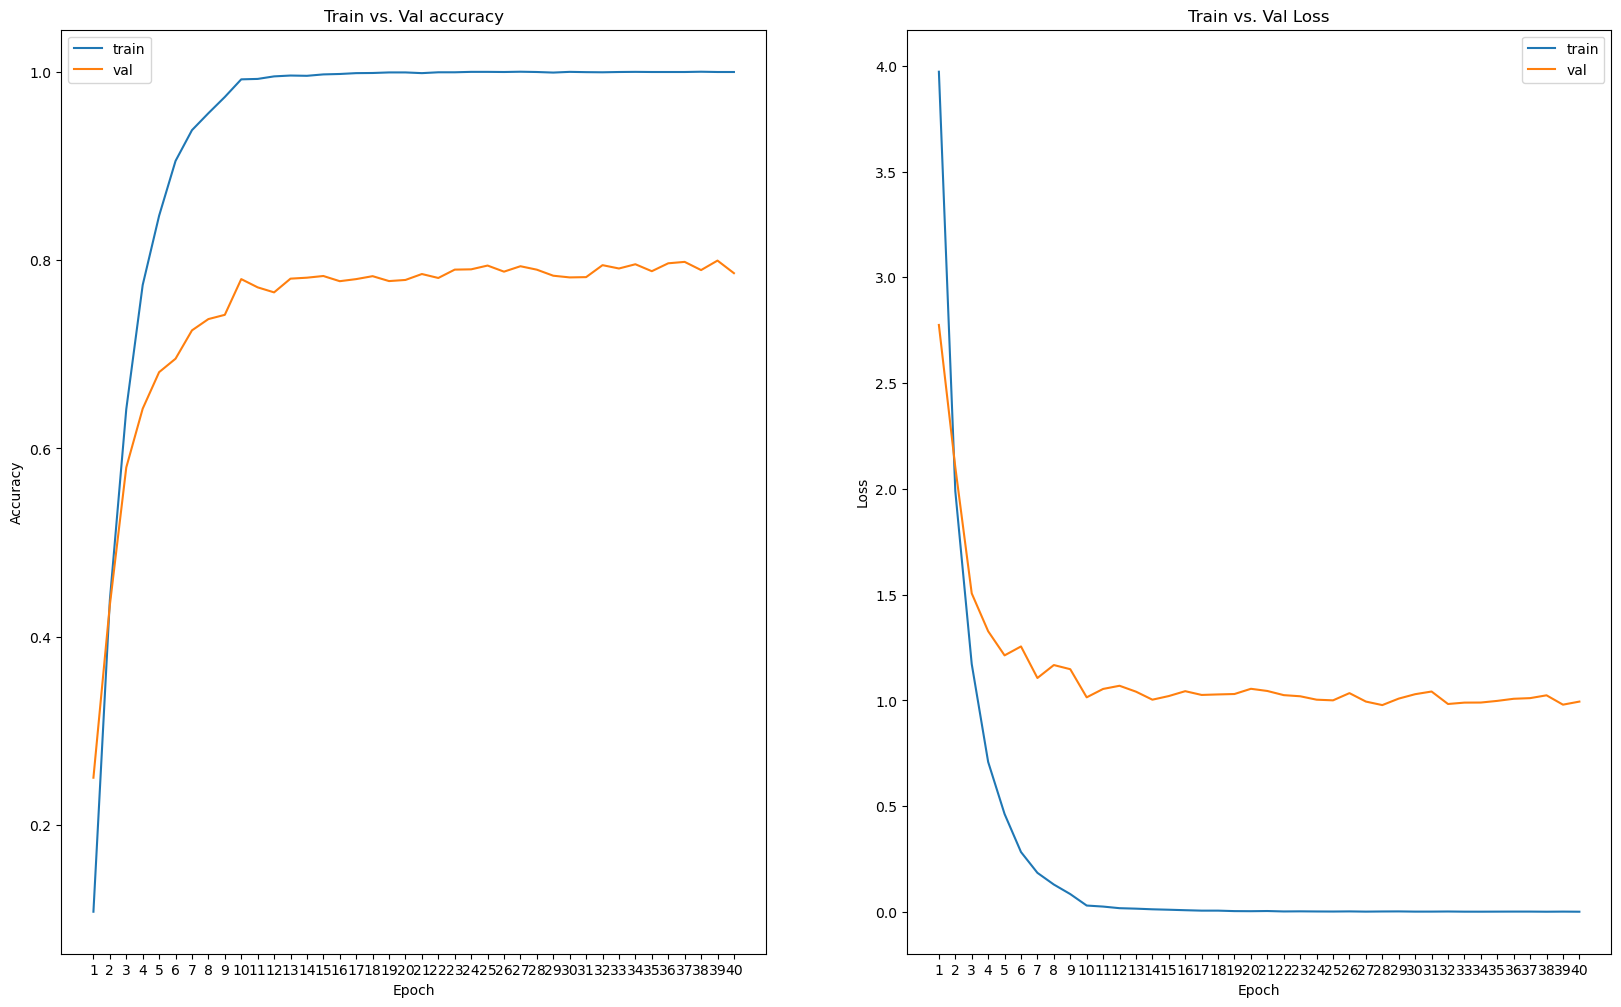

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
xticks = np.arange(1, len(history["train_accuracy"]) + 1)

ax[0].plot(history["train_accuracy"], label="train")
ax[0].plot(history["val_accuracy"], label="val")
ax[0].set_xticks(np.arange(len(history["train_accuracy"])), xticks)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend()
ax[0].set_title("Train vs. Val accuracy")

ax[1].plot(history["train_loss"], label="train")
ax[1].plot(history["val_loss"], label="val")
ax[1].set_xticks(np.arange(len(history["train_accuracy"])), xticks)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()
ax[1].set_title("Train vs. Val Loss")
plt.show()